**Build-up of halos**

In [1]:
# load some standard python tools
%matplotlib inline
import numpy as np
import importlib
import matplotlib.pyplot as plt 
import sys
import os
import re
# MNRAS TeX style
useMN = False
import matplotlib.pyplot as plt
if useMN:
    plt.style.use('../paper.mplstyle')
#
import pickle
# Do we need these? Would be good to show?
# from astropy.io import ascii
# from astropy import constants as constants
# import astropy.units as units
import random
from importlib import reload
import csv
import scipy.interpolate as interpolate
from scipy import interpolate
import scipy.integrate as integrate
# colossus package
from colossus.cosmology import cosmology as ccosmology
from colossus.lss import mass_function
from colossus.lss import bias
# These are not available either
# import matplotlib.cm as cm
# from mpltools import color
from matplotlib import rc
from num2tex import num2tex
from num2tex import configure as num2tex_configure
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
plt.rcParams.update({'font.size': 17})
num2tex_configure(exp_format='times')
fontsize=20
#
import copy
import time
from astropy.table import Table
#from astropy import constants as constants
from astropy.constants import astropyconst20 as constants
import astropy.units as units
font = {'size':18}
plt.rc('font', **font)
# database
import eagleSqlTools as sql
me     = "tt"
mine   = "vr983MZL"
conSQL = sql.connect(me, password=mine)
import swiftsimio as sw
# hdf5
import h5py

# import read eagle
import pyread_eagle as read_eagle

num2tex configure options:
 - help_text: boolean whether this help text is displayed when configure() is called
 - exp_format: string format specification for how the power of 10 is displayed in scientific format.
     - also accepts specifiers 'times', which is converted to '\times 10^{}', 'cdot': '\cdot 10^{}', and 'parentheses': '(10^{})'
 - display_singleton: boolean on whether the "1 \times" is printed in "1 \times 10^{p}"
          


In [2]:
# Create a dictionary of physical constants from astropy. Each constant is stored in cgs (centimetre, gram, seconds)
# Physical constants
c           = (constants.c.cgs / units.cm * units.s).value # speed of light
Grav        = (constants.G.cgs / units.cm**3 * units.s**2 * units.g).value  # Newton's constant [cm^3/s^2/g]
mH          = (constants.m_p.cgs / units.g).value                           # Proton mass [g]
me          = (constants.m_e.cgs / units.g).value                           # electron mass [g]
planck      = constants.h.cgs.value      # Planck's constant [erg s]
boltz       = constants.k_B.cgs.value    # Boltzmann constants [erg/K]
eps0        = 1./(4e0*np.pi)             # Permitivity of free space [-] 
e           = constants.e.esu.value      # electron charge [Fr]
sigma       = 6.63e-18                   # HI photo-ionisation cross section [cm^2]
sigmaT      = 1e4 * constants.sigma_T.value # Thomson cross-section in cm^2



# Astrophysical constants
GMsun       = (constants.GM_sun.cgs * units.s**2 / units.cm**3).value
Msun        = (constants.M_sun.cgs / units.g).value
pc          = (constants.pc.cgs / units.cm).value
kpc         = 1e3 * pc
Mpc         = 1e6 * pc
H100        = 100. * 1e5 / Mpc
micron      = 1e-4       # micron in cm
yr          = 3.15576e7  # year in seconds

# common conversion factors
eV          = constants.e.value * 1e7 # 1 electron volt in g (cm/s)^2
Ryd         = me * (e**2/(4.*np.pi*eps0))**2 * (4*np.pi)**2 / (8 * planck**2) # 1 Rydberg in g (cm/s)^2

phys = {'c':c, 'Grav':Grav, 'mH':mH, 'me':me, 'planck':planck, 'kB':boltz, 'sigma':sigma, 'sigmaT':sigmaT, 'eps0':eps0, 'e':e, 
        'GMsun':GMsun, 'Msun':Msun, 'pc':pc, 'kpc':kpc, 'Mpc':Mpc, 'micron':micron, 'yr':yr, 'H100':H100, 
        'eV':eV, 'Ryd':Ryd}

# cosmology values
h         = 0.677
H0        = h * 100 * 1e5 / (1e6 * phys["pc"])  # Hubble parameter
cosmology = {'h':0.677, 'H0':H0, 'Omegam':0.3}

# correa model
correa      = {'a':0.24,'b': 0.75}
def Mh(z, a=correa["a"], b=correa["b"]):
  ''' Halo mass at redshift z, in units of its value at z=0 '''
  return (1.+z)**a * np.exp(-b*z)

def dlnMhdz(z, a=correa["a"], b=correa["b"]):
  ''' (dMh/dz) / Mh at redshift z '''
  return a/(1.+z) - b

def Hubble(z):
  ''' Hubble constant at redshift z '''
  return cosmology["H0"] * np.sqrt(cosmology["Omegam"]*(1+z)**3 + 1. - cosmology["Omegam"])
def dzdt(z):
  return -(1+z) * Hubble(z)


## Class to query databases of halos and particles

In [3]:
simname   = {'sql':'RefL0100N1504', 'particles':'L0100N1504/PE/REFERENCE'}
sqlpars   = {'m_min':5e11, 'm_max':1e12, 'fraction':0.1}
sphere    = {'centre':[1., 1.0, 1.0], 'radius':1.0}
variables = [{'type':1, 'name':'Coordinates'}]
snapnum   = 28
class EagleMergerTree:
    def __init__(self, simname=simname, sqlpars=sqlpars):
        ''' Methods to interface SQL database and particles from snapshots '''
        #self.eaglebase  = '/cosma7/data/Eagle/ScienceRuns/Planck1/'  # location of eagle snapshots
        self.eaglebase = '/home/cristobal/Documents/mnt/eagle/'
        self.simname    = simname   # particlular simulation
        self.subbase    = 'particledata_'
        self.partbase   = 'eagle_subfind_particles_'

        # read cosmological parameters
        # create file name
        file            = self.eaglebase + self.simname['particles'] + '/data/' + self.subbase 
        file           += self.snapbase(snapnum) + '/' + self.partbase + self.snapbase(snapnum) + '.0.hdf5'
        self.fname      = file
        self.snapheader = self.ReadHeader()
        

        
    def QueryDB(self, sqlpars, snapnum=28):
        ''' Query data base'''
        mhistory = 'SELECT \
                          DES.GalaxyID as galaxyID, \
                          PROG.GalaxyID as progenitorID, \
                          DES.TopLeafID as topleafID, \
                          DES.LastProgID as lastprogID, \
                          PROG.DescendantID as descendantID, \
                          DES.GroupNumber as descgroup, \
                          DES.SubGroupNumber as descsubgroup, \
                          PROG.GroupID as groupID, \
                          PROG.GroupNumber as groupnumber, \
                          PROG.SubGroupNumber as subgroupnumber, \
                          PROG.CentreOfMass_x as x,\
                          PROG.CentreOfMass_y as y, \
                          PROG.CentreOfMass_z as z,\
                          PROG.HalfMassRad_DM as rad, \
                          PROG.Redshift as redshift, \
                          PROG.Vmax as vmax, \
                          PROG.MassType_DM as mass, \
                          PROG.MassType_Star as mstar, \
                          PROG.SF_Mass as sfgas, \
                          PROG.NSF_Mass as nsfgas, \
                          PROG.Snapnum as snapnum, \
                          PROG.Starformationrate as SFR, \
                          PROG.GroupID as fof_ID, \
                          FOF.Group_R_Crit200 as fof_r200, \
                          FOF.Group_M_Crit200 as fof_mass, \
                          FOF.GroupCentreOfPotential_x as fof_x, \
                          FOF.GroupCentreOfPotential_y as fof_y, \
                          FOF.GroupCentreOfPotential_z as fof_z \
                  FROM \
                          {0}_Subhalo as PROG, \
                          {0}_Subhalo as DES, \
                          {0}_FOF as FOF \
                  WHERE \
                          DES.MassType_DM between {1:1.2e} and {2:1.2e} \
                          and DES.RandomNumber < {3:1.3f} \
                          and DES.SnapNum = {4:3d} \
                          and DES.SubGroupNumber = 0 \
                          and PROG.GalaxyID between DES.GalaxyID and DES.LastProgID \
                          and PROG.GroupID = FOF.GroupID \
                          and PROG.spurious = 0 \
                  ORDER BY \
                          PROG.Redshift asc'.format(self.simname['sql'], sqlpars['m_min']
                                                    , sqlpars['m_max'], sqlpars['fraction']
                                                    , snapnum)
        return sql.execute_query(conSQL, mhistory)

 
    def QuerySnap(self, sphere=sphere, variables=variables, convert_h=True, snapnum=28, verbose=False):
        '''
        Return particles within a given spherical region, looping over all requested variables
        convert_h: if True, convert variables to no h
        '''
        xrange = sphere['centre'][0] + sphere['radius'] *  np.array([-1., 1.])
        yrange = sphere['centre'][1] + sphere['radius'] *  np.array([-1., 1.])
        zrange = sphere['centre'][2] + sphere['radius'] *  np.array([-1., 1.])

        # open file
        snap      = read_eagle.EagleSnapshot(self.fname)
        # set region to read
        snap.select_region(xrange[0], xrange[1], yrange[0], yrange[1], zrange[0], zrange[1])
        # outcome for every particle type
        Parts = {}
        for i in np.arange(6):
            Parts[i] = {}
        for variable in variables:
            ptype   = variable['type']
            varname = variable['name']
            pname   = 'PartType{0:1d}'.format(ptype)
            group   = pname + '/' + varname
            info    = self.ReadGroup(groupname = group)
            try:
                Values    = snap.read_dataset(ptype, varname)
                if convert_h and np.abs(info['h-scale-exponent'])>0:
                    hfactor = (self.snapheader["Cosmo"]["HubbleParam"])**info['h-scale-exponent']
                    Values *= hfactor
                    info['h-scale-exponent'] = 0.0
                if verbose:
                    print("Read type {0:2d}, name = {1:s}, length: {2:1.3e}"
                          .format(ptype, varname, len(Values)))
            except:
                print("Failed to read ", variable)
                pass
            Parts[ptype][varname] = {'Values': Values, 'Info': info}

            
        return Parts
        
        
    def snapbase(self, snapnum=28):
        ''' return file base for particle file '''
        bases      = ['000_z020p000', '001_z015p132', '002_z009p993'
                  , '003_z008p988', '004_z008p075', '005_z007p050'
                  , '006_z005p971', '007_z005p487', '008_z005p037'
                  , '009_z004p485', '010_z003p984', '011_z003p528'
                  , '012_z003p017', '013_z002p478', '014_z002p237'
                  , '015_z002p012', '016_z001p737', '017_z001p487'
                  , '018_z001p259', '019_z001p004', '020_z000p865'
                  , '021_z000p736', '022_z000p615', '023_z000p503'
                  , '024_z000p366', '025_z000p271', '026_z000p183'
                  , '027_z000p101', '028_z000p000']
        try:
            return bases[snapnum]
        except:
            print('This snapshot does not exists, sorry')

    def SetUnit(self, vardescription = 'text describing variable', Lunit=phys['Mpc'], aFact=1.0, hFact=1.0):
        ''' Set units of a variable '''
        return {'VarDescription': vardescription, 'CGSConversionFactor':Lunit, 'aexp-scale-exponent' :aFact, 'h-scale-exponent': hFact}
        
    def ReadHeader(self):
        ''' Read cosmological parameters'''
        #
        # read header information and store in default format
        header = self.ReadGroup()

        # the unit and h-dependence of Eagle is not stated; We assume it is in cMpc/h
        boxsize  = np.array([1., 1.0, 1.0 ]) * header['BoxSize']
        boxunit  = self.SetUnit(vardescription="Extent of simulation volume", 
                                Lunit=phys['Mpc'], 
                                aFact=1.0, 
                                hFact=-1.0)
        box      = {'Value':boxsize, 'Info':boxunit}
        h        = header['HubbleParam']
        #
        cosmo    = {'Redshift'    : header['Redshift'], 
                    'HubbleParam' : h,
                    'OmegaMatter' : header['Omega0'],
                    'OmegaBaryon' : header['OmegaBaryon'],
                    'OmegaLambda' : header['OmegaLambda']}

        numpartval   = header['NumPart_Total'][0]
        numpartunit  = self.SetUnit(vardescription="Total number of gas particles in the simulation", 
                                Lunit=1, 
                                aFact=0, 
                                hFact=0)
        numpart      = {'Value':numpartval,'Info':numpartunit}

        # compute some extra variables
        H0            = h * 100 * 1e5 / phys["Mpc"]      # H0 in 1/s
        rhoc          = 3*H0**2 / (8*np.pi*phys["Grav"]) # critical density in g/cm^3
        cosmo["H0"]   = H0
        cosmo["rhoc"] = rhoc
        cosmo["rhob"] = rhoc * cosmo["OmegaBaryon"]
            
        Header = {'BoxSize':box, 'Cosmo' : cosmo, 'NumPartTot':numpart}
        
        return Header
       
    def ReadGroup(self, groupname ='Header'):
        # read all entries for this particular hdf5 group
        hfile = h5py.File(self.fname, "r")
        group    = hfile[groupname]
        grp_dict = {}
        for k in group.attrs.keys():
            grp_dict[k]= group.attrs[k]
        
        hfile.close()
    
        return dict(grp_dict)
    
simname      = {'sql':'RefL0100N1504', 'particles':'L0100N1504/PE/REFERENCE'}
sqlpars      = {'m_min':5e11, 'm_max':1e12, 'fraction':0.2}
mtree        = EagleMergerTree(simname=simname, sqlpars=sqlpars)
HubbleParam  = mtree.snapheader['Cosmo']["HubbleParam"]

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/cosma7/data/Eagle/ScienceRuns/Planck1/L0100N1504/PE/REFERENCE/data/particledata_028_z000p000/eagle_subfind_particles_028_z000p000.0.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [477]:
# query database
snapnum   = 28
dbase     = mtree.QueryDB(sqlpars, snapnum=snapnum)
variables = dbase.dtype.names
for variable in variables:
    print("read: ", variable)

read:  galaxyID
read:  progenitorID
read:  topleafID
read:  lastprogID
read:  descendantID
read:  descgroup
read:  descsubgroup
read:  groupID
read:  groupnumber
read:  subgroupnumber
read:  x
read:  y
read:  z
read:  rad
read:  redshift
read:  vmax
read:  mass
read:  mstar
read:  sfgas
read:  nsfgas
read:  snapnum
read:  SFR
read:  fof_ID
read:  fof_r200
read:  fof_mass
read:  fof_x
read:  fof_y
read:  fof_z


## Galaxy build-up

Extract galaxy build-up history from data base

In [584]:
from scipy.interpolate import CubicSpline
from scipy.optimize import curve_fit

def fit_growth(z, mass):
    # determine constants a and b from above
    spline = CubicSpline(np.log10(mass), z)
    logms  = np.log10(np.max(mass)) + [np.log10(1./2.), - np.log10(3./4.)]
    fit    = spline(logms)
    return fit

def fit_correa(z, Mh0, a, b):
    ''' Halo growth function Mh(z) = Mh0 * (1+z)^a exp(-bz)'''
    return Mh0*(1+z)**a*np.exp(-b*z)

def zform(a, b):
    zfit = np.arange(10,0,-0.01)
    mfit = (1+zfit)**a * np.exp(-zfit*b)
    z0p5 = np.max(zfit[mfit > 0.5])
    return z0p5

In [586]:
# extract all progenitors for each snapmax galaxy
snapmax      = 28
mask         = dbase['snapnum'] == snapmax
descIDs      = dbase['galaxyID'][mask]
topleafIDs   = dbase['topleafID'][mask]
lastprogIDs  = dbase['lastprogID'][mask]

myvars  = ['progenitorID', 'fof_ID', 'fof_mass', 'snapnum', 'redshift', 'SFR', 'mstar', 'sfgas']
mhist   = {}
for i, (descID, topleafID, lastprogID) in enumerate(zip(descIDs, topleafIDs, lastprogIDs)):
    mhist[i]  = {}
    mask      = (dbase["progenitorID"] >= descID) & (dbase['progenitorID'] <= lastprogID)
    mhist[i]['descendantID']  = descID
    mhist[i]['topleafID']     = topleafID
    mhist[i]['lastprogID']    = lastprogID
    for var in myvars:
        mhist[i][var] = dbase[var][mask]


In [585]:
# for i in np.arange(10):
#     print(mhist[i]['topleafID'])

In [622]:
# extract merger history for each galaxy
def mergerhist(mhist=mhist[0]):
    result     = {}
    progid     = mhist['progenitorID']
    topleafid  = mhist['topleafID']
    descid     = mhist['descendantID']
    snapnums   = mhist['snapnum']
    redshifts  = mhist['redshift']
    fofids     = mhist['fof_ID']
    # fof id of main progenitor
    mask       = (progid >= descid) & (progid <= topleafid)
    mainfofids = fofids[mask]
    snaps      = snapnums[mask]
    reds       = redshifts[mask]
    fofmass    = mhist['fof_mass'][mask]
    #
    result['descendantID'] = descid
    result['snapnum']      = snaps
    result['redshift']     = reds
    result['fof_mass']     = fofmass
    myvars = ['SFR', 'mstar', 'sfgas']
    #
    for var in myvars:
        result[var] = []
    #
    for snap, mainfofid in zip(snaps, mainfofids):
        #
        mask   = (snapnums == snap) & (fofids == mainfofid)
        for var in myvars:
            result[var].append(np.sum(mhist[var][mask]))

    for var in myvars:
        result[var] = np.array(result[var])
        
    # fit halo growth function parameters
    mask      = (reds < 4) & (reds > 1)
    zfof      = reds[mask]
    mfof      = result['fof_mass'][mask]
    #
    Mhbounds  = [1e10, 5e12]
    lbounds   = [1e10, 0.1, 0.1]
    ubounds   = [5e12, 2, 2]
    bounds    = [lbounds, ubounds]
    Mh0, a, b = curve_fit(fit_correa, zfof, mfof, bounds=bounds)[0]
    #
    result['Mh0'] = Mh0
    result['a']   = a
    result['b']   = b
    return result

history = {}
for i, descID in enumerate(descIDs):
    history[i] = mergerhist(mhist=mhist[i])
print("Calculation finished")

Calculation finished


In [625]:
# Test variance in gas mass
snapnum = 15 # reference redshift


myvars = ['fof_mass', 'SFR', 'mstar', 'sfgas', 'redshift']
ovars  = ['a', 'b', 'Mh0']
stats  = {}
for var in myvars:
    stats[var] = []

for var in ovars:
    stats[var] = []

for i, descID in enumerate(descIDs):
    snaps = history[i]['snapnum']
    mask  = snaps == snapnum
    for var in myvars:
        stats[var].append(history[i][var][mask][0])
    for var in ovars:
        stats[var].append(history[i][var])
#                 
for var in myvars:
    stats[var] = np.array(stats[var])
print("Calculation finished")

In [626]:
print(stats['redshift'][0:5])

[2.0124102 2.0124102 2.0124102 2.0124102 2.0124102]


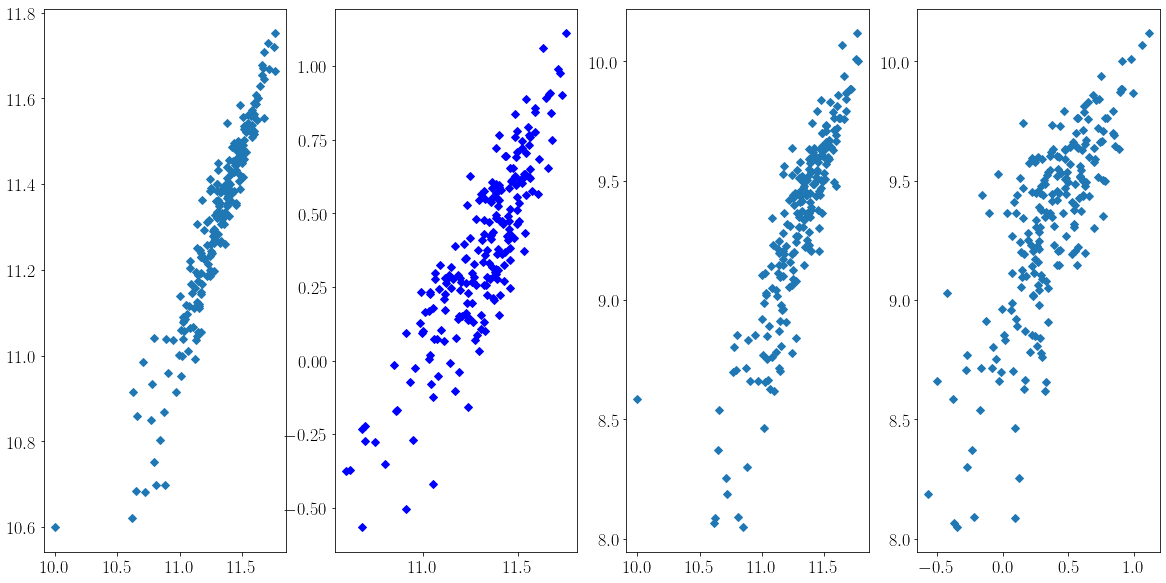

In [636]:
fig, ax = plt.subplots(1,  4, figsize = (20, 10))

zref      = stats['redshift'][0]
a         = np.array(stats['a'])
b         = np.array(stats['b'])
Mh0       = np.array(stats['Mh0'])
Mpred     = fit_correa(zref, Mh0, a, b)
Mgpred    = -(a/(1+zref)-b) * (Mpred/1e11)**(5./3.)


ax[0].plot(np.log10(stats['fof_mass']), np.log10(Mpred), 'D')
ax[1].plot(np.log10(Mpred), np.log10(Mgpred), 'D', color='blue')
ax[2].plot(np.log10(stats['fof_mass']), np.log10(stats['sfgas']), 'D')
ax[3].plot(np.log10(Mgpred), np.log10(stats['sfgas']), 'D')


# ax[0].plot(np.log10(stats['fof_mass']), np.log10(stats['sfgas']), 'D')



fig.show()

In [647]:
def fit_MdmMg(LogMdm, LogMgas, power):
    ''' function to relate fof mass to gass mass '''
    return LogMgas + power * (LogMdm-11.)
Logmdm  = np.log10(stats['fof_mass'])
Logmgas = np.log10(stats['sfgas'])
#
lbounds   = [4, 0.1]
ubounds   = [12, 2]
bounds    = [lbounds, ubounds]
LogMgas, power = curve_fit(fit_MdmMg, Logmdm, Logmgas, bounds=bounds)[0]
print(LogMgas, power)
        

8.890741846293057 1.4233124106673471


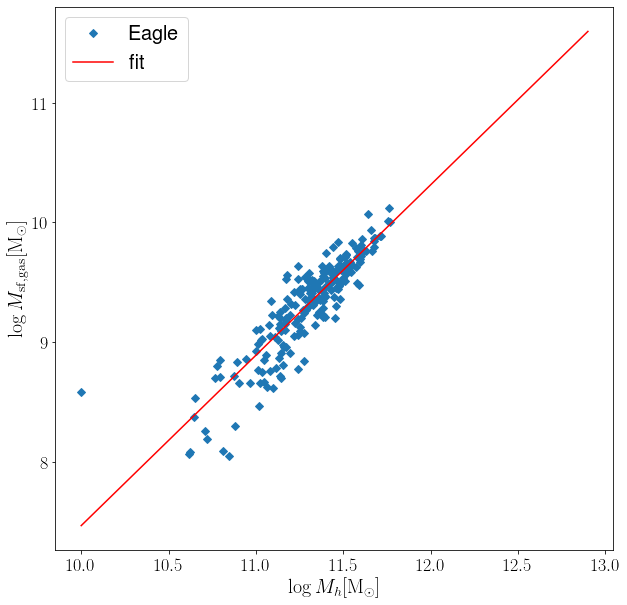

In [648]:
# plot and fit relation fof-mass 
fig, ax = plt.subplots(1,  1, figsize = (10, 10))

ax.plot(Logmdm, Logmgas, 'D', label='Eagle')
LogMdmfit = np.arange(10, 13, 0.1)
ax.plot(LogMdmfit, fit_MdmMg(LogMdmfit, LogMgas, power), color='red', label='fit')
ax.set_xlabel(r"$\log M_h [{\rm M}_\odot]$", fontsize=fontsize)
ax.set_ylabel(r"$\log M_{\rm sf, gas} [{\rm M}_\odot]$", fontsize=fontsize)
ax.legend(fontsize=fontsize)
fig.show()

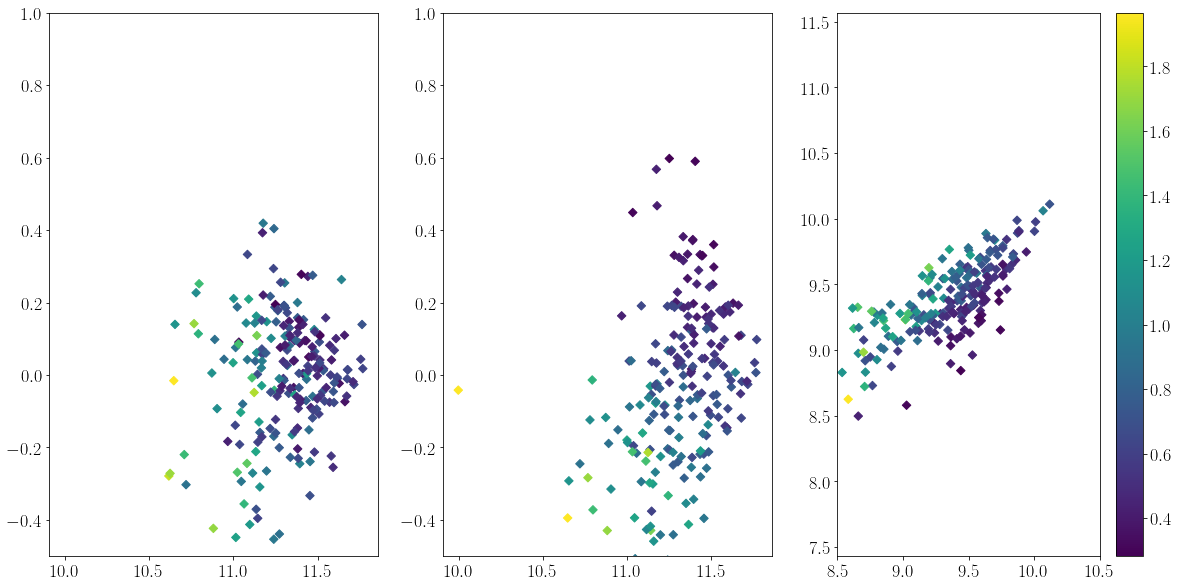

In [667]:
# plot scatter compared to fit
LogMgasfit = fit_MdmMg(Logmdm, LogMgas, power)

# scatter from model
zref      = stats['redshift'][0]
a         = np.array(stats['a'])
b         = np.array(stats['b'])
Mh0       = np.array(stats['Mh0'])
Mpred     = fit_correa(zref, Mh0, a, b)             # predicted halo mass
norm      =  -(a/(1+zref)-b)
Mgpred    = norm * (Mpred/1e11)**(5./3.) # predicted gas mass




fig, ax = plt.subplots(1,  3, figsize = (20, 10))

# intrinsic scatter, coloured by b value
sc = ax[0].scatter(Logmdm, Logmgas-LogMgasfit, c=norm, marker='D')
plt.colorbar(sc)

# scatter from model
# normalize to 10^9 solar masses at Mpred = 11
sc2 = ax[1].scatter(Logmdm, Logmgas - (9 + np.log10(Mgpred)), c=norm, marker='D')

ax[2].scatter(Logmgas, 9 + np.log10(Mgpred), c=norm, marker='D')
ax[2].axis('equal')
ax[2].set_xlim(8.5, 10.5)
ax[2].set_ylim(8.5, 10.5)
for i in np.arange(2):
    ax[i].set_ylim(-0.5, 1)
fig.show()

## Main branch build-up history

In [ ]:
fig, ax = plt.subplots(1,  1, figsize = (20, 10))

snapmax      = 28
mask         = dbase['snapnum'] == snapmax
descIDs      = dbase['galaxyID'][mask]
topleafIDs   = dbase['topleafID'][mask]
descMasses   = dbase['mass'][mask]

for i, (descID, topleafID, descMass) in enumerate(zip(descIDs, topleafIDs, descMasses)):
    if i == 13:
        galaxyID = descID
        mask  = (dbase["progenitorID"] >= descID) & (dbase['progenitorID'] <= topleafID)
        snaps = dbase['snapnum'][mask]
        mass  = dbase['mass'][mask]
        ax.plot(snaps, np.log10(mass/descMass), 'D-', label=r"{0:2d}".format(i))

print(galaxyID)
ax.legend(ncol=3)
fig.show()

log Mh0 = 12.00, a = 0.10, b=0.64, z0p5 = 1.20
log Mh0 = 11.81, a = 0.52, b=1.00, z0p5 = 1.07
log Mh0 = 12.22, a = 0.18, b=1.00, z0p5 = 0.79
log Mh0 = 12.01, a = 0.10, b=0.75, z0p5 = 1.02
log Mh0 = 11.65, a = 1.00, b=0.68, z0p5 = 3.10


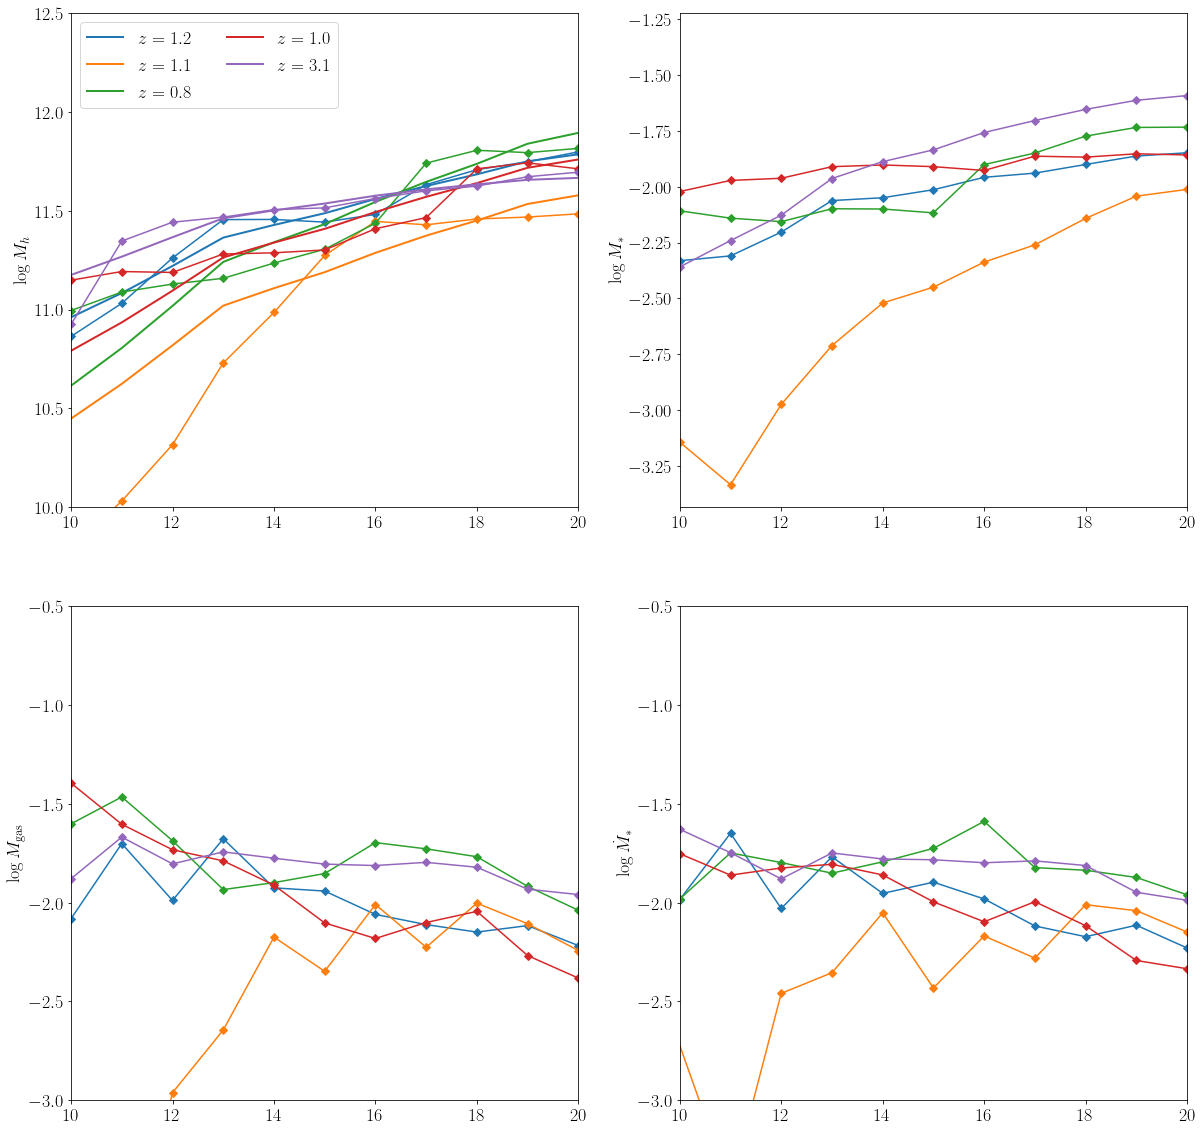

In [547]:
# Compare Fof mass to sum of subfind masses

# build-up of FOF mass
snapmax      = 19
mask         = dbase['snapnum'] == snapmax
descIDs      = dbase['galaxyID'][mask]
topleafIDs   = dbase['topleafID'][mask]
descMasses   = dbase['mass'][mask]
fig, ax = plt.subplots(2,  2, figsize = (20, 20))


nplot   = 5
plt.gca().set_prop_cycle(
plt.cycler('color', plt.cm.CMRmap(np.linspace(0., 1., nplot + 1))))
cycle   = plt.rcParams['axes.prop_cycle'].by_key()['color']
nsys    = np.arange(nplot)
#

for i, (isys, descID, topleafID, descMass) in enumerate(zip(nsys, descIDs, topleafIDs, descMasses)):
    color = cycle[isys]
    if i < nplot:
        # properties of fof halo
        mask     = (dbase["progenitorID"] >= descID) & (dbase['progenitorID'] <= topleafID)
        progs    = dbase['progenitorID'][mask]
        snaps    = dbase['snapnum'][mask]
        redshift = dbase['redshift'][mask]
        fofmass  = dbase['fof_mass'][mask]
        fofids   = dbase['fof_ID'][mask]
        ax[0,0].plot(snaps, np.log10(fofmass), 'D-', color=color)
        
        # fit correa growth
        mask = (redshift < 4) & (redshift > 1)
        Mhbounds  = [1e10, 5e12]
        abounds   = [0.1, 0.5] # mean is 0.24
        bbounds   = [0.5, 1.0] # mean is 0.75
        lbounds   = [1e10, 0.1, 0.1]
        ubounds   = [5e12, 1, 1]
        bounds    = [lbounds, ubounds]
        Mh0, a, b = curve_fit(fit_correa, redshift[mask], fofmass[mask], bounds=bounds)[0]
        Mhfit     = fit_correa(redshift, Mh0, a, b)
        z0p5 = zform(a,b)
        print("log Mh0 = {0:1.2f}, a = {1:1.2f}, b={2:1.2f}, z0p5 = {3:1.2f}".format(np.log10(Mh0),a,b, z0p5))
        ax[0,0].plot(snaps, np.log10(Mhfit), color=color,lw=2, label=r"$z={0:1.1f}$".format(z0p5))

        # sum stellar masses of groups in this fof halo
        mstars = []
        sfgas  = []
        sfr    = []
        for snap, fofid in zip(snaps, fofids):
            mask = (dbase['snapnum']==snap) & (dbase['fof_ID']==fofid)
            mstars.append(np.sum(dbase["mstar"][mask]))
            sfgas.append(np.sum(dbase["sfgas"][mask]))
            sfr.append(np.sum(dbase["SFR"][mask]))

        mstars = np.array(mstars)
        sfgas  = np.array(sfgas)
        sfr    = np.array(sfr)
        ax[0,1].plot(snaps[mstars>0], np.log10(mstars[mstars>0]/Mhfit[mstars>0]), 'D-', color=color)
        ax[1,0].plot(snaps[sfgas>0], np.log10(sfgas[sfgas>0]/Mhfit[sfgas>0]), 'D-', color=color)
        #ax[1,1].plot(snaps[sfr>0], np.log10(sfr[sfr>0]/Mhfit[sfr>0]), 'D-', color=color)
        ax[1,1].plot(snaps[sfgas>0], np.log10(sfgas[sfgas>0]/fofmass[sfgas>0]), 'D-', color=color)
ax[0,0].set_ylabel(r"$\log M_h$")
ax[0,0].legend(ncol=2, loc='upper left')
ax[0,1].set_ylabel(r"$\log M_\ast$")
ax[1,0].set_ylabel(r"$\log M_{\rm gas}$")
ax[1,1].set_ylabel(r"$\log \dot M_\ast$")
for i in np.arange(0,2,1):
    for j in np.arange(0,2,1):
        ax[i,j].set_xlim(10, 20)
#ax[0,0].set_ylim(10, 0.5)        
ax[0,0].set_ylim(10, 12.5)
#ax[0,1].set_ylim(-2, 0.5)
#ax[1,0].set_ylim(-2, 3)
#ax[1,1].set_ylim(-2, 3)
for j in np.arange(2):
    ax[1,j].set_ylim(-3, -0.5)
fig.show()

In [522]:
# sf gas mass seems to depend on halo mass a long time ago
snapmax    = 28   # current time
snapmin    = 20   # earlier time
snapshots  = [snapmin, snapmax]

mask         = dbase['snapnum'] == snapmax
descIDs      = dbase['galaxyID'][mask]
topleafIDs   = dbase['topleafID'][mask]
descMasses   = dbase['mass'][mask]

results = {}
myvars  = ['mstar', 'sfgas', 'SFR']
for snap in snapshots:
    results[snap] = {}
    for var in myvars:
        results[snap][var] = []
    results[snap]['m'] = []

for i, (descID, topleafID) in enumerate(zip(descIDs, topleafIDs)):
    mask       = (dbase["progenitorID"] >= descID) & (dbase['progenitorID'] <= topleafID)
    progs      = dbase['progenitorID'][mask]
    snaps      = dbase['snapnum'][mask]
    redshifts  = dbase['redshift'][mask]
    fofmasses  = dbase['fof_mass'][mask]
    fofids     = dbase['fof_ID'][mask]
    #
    for snap in snapshots:
        #
        mask     = snaps == snap
        fof      = fofids[mask]
        fofmass  = fofmasses[mask][0]
        redshift = redshifts[mask][0]
        fofid    = fofids[mask][0]
        #
        results[snap]['m'].append(fofmass)
        results[snap]['redshift'] = redshift
        for var in myvars:
            # sum over all groups in this fof halo
            mask     = (dbase['snapnum']==snap) & (dbase['fof_ID']==fofid)
            results[snap][var].append(np.sum(dbase[var][mask]))

for snap in snapshots:
    for var in myvars:
        results[snap][var] = np.array(results[snap][var])
    results[snap]['m'] = np.array(results[snap]['m'])
    

/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


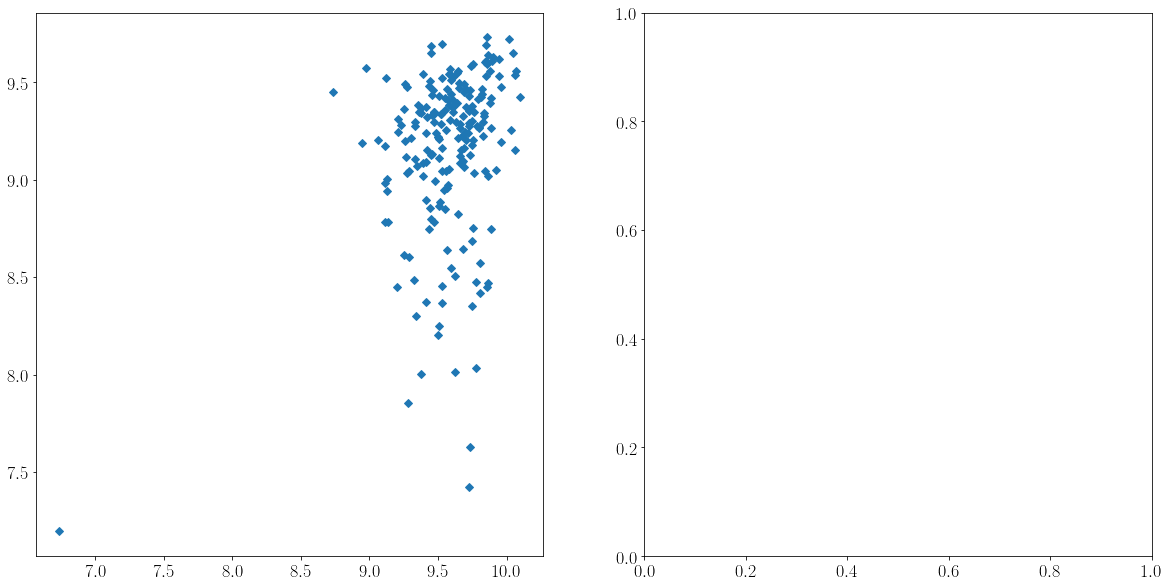

In [524]:
fig, ax = plt.subplots(1,  2, figsize = (20, 10))

ax[0].plot(np.log10(results[20]['sfgas'][:]), np.log10(results[28]['sfgas'][:]/results[20]['sfgas'][:]), 'D')

fig.show()

In [478]:
# specific sfr versus zform
results = {}
snapmax      = 28
mask         = dbase['snapnum'] == snapmax
descIDs      = dbase['galaxyID'][mask]
topleafIDs   = dbase['topleafID'][mask]
descMasses   = dbase['mass'][mask]

for i, (descID, topleafID, descMass) in enumerate(zip(descIDs, topleafIDs, descMasses)):

    results[i] = {}
    
    # properties of fof halo
    mask     = (dbase["progenitorID"] >= descID) & (dbase['progenitorID'] <= topleafID)
    progs    = dbase['progenitorID'][mask]
    snaps    = dbase['snapnum'][mask]
    redshift = dbase['redshift'][mask]
    fofmass  = dbase['fof_mass'][mask]
    fofids   = dbase['fof_ID'][mask]

    # fit correa growth
    mask = redshift < 3
    abounds = [0.1, 0.5]
    bbounds = [0.5, 1.0]
    bounds  = [abounds, bbounds]
    a, b = curve_fit(fit_correa, redshift[mask], fofmass[mask]/fofmass[0], bounds=bounds)[0]
    z0p5 = zform(a,b)
    results[i]['z0p5'] = z0p5
    
    # sum stellar masses of groups in this fof halo
    mstars = []
    sfgas  = []
    sfr    = []
    mh     = []
    for snap, fofid in zip(snaps, fofids):
        mask = (dbase['snapnum']==snap) & (dbase['fof_ID']==fofid)
        mstars.append(np.sum(dbase["mstar"][mask]))
        sfgas.append(np.sum(dbase["sfgas"][mask]))
        sfr.append(np.sum(dbase["SFR"][mask]))
        mh.append(dbase["mass"][mask][0])

    results[i]["Mh0"]     = descMass
    results[i]["z"]       = np.array(redshift)
    results[i]["snapnum"] = np.array(snaps)
    results[i]["sfr"]     = np.array(sfr)
    results[i]["sfgas"]   = np.array(sfgas)
    results[i]["mstar"]   = np.array(mstars)
    results[i]["m"]       = np.array(mh)


0 9746293 20 0.86505055 11.908382
0 9746293 28 2.220446e-16 11.962005
1 9186582 20 0.86505055 11.894278
1 9186582 28 2.220446e-16 12.006995
2 9361156 20 0.86505055 11.870792
2 9361156 28 2.220446e-16 11.916764
3 10069224 20 0.86505055 11.607697
3 10069224 28 2.220446e-16 11.736731
4 9132632 20 0.86505055 11.846634
4 9132632 28 2.220446e-16 11.985673
5 9260962 20 0.86505055 11.688644
5 9260962 28 2.220446e-16 12.042675
6 9401631 20 0.86505055 11.697256
6 9401631 28 2.220446e-16 11.911795
7 9869935 20 0.86505055 11.753392
7 9869935 28 2.220446e-16 11.931174
8 9101581 20 0.86505055 11.906766
8 9101581 28 2.220446e-16 11.7932825
9 9222263 20 0.86505055 11.340325
9 9222263 28 2.220446e-16 11.9748535


/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10
/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10
/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10


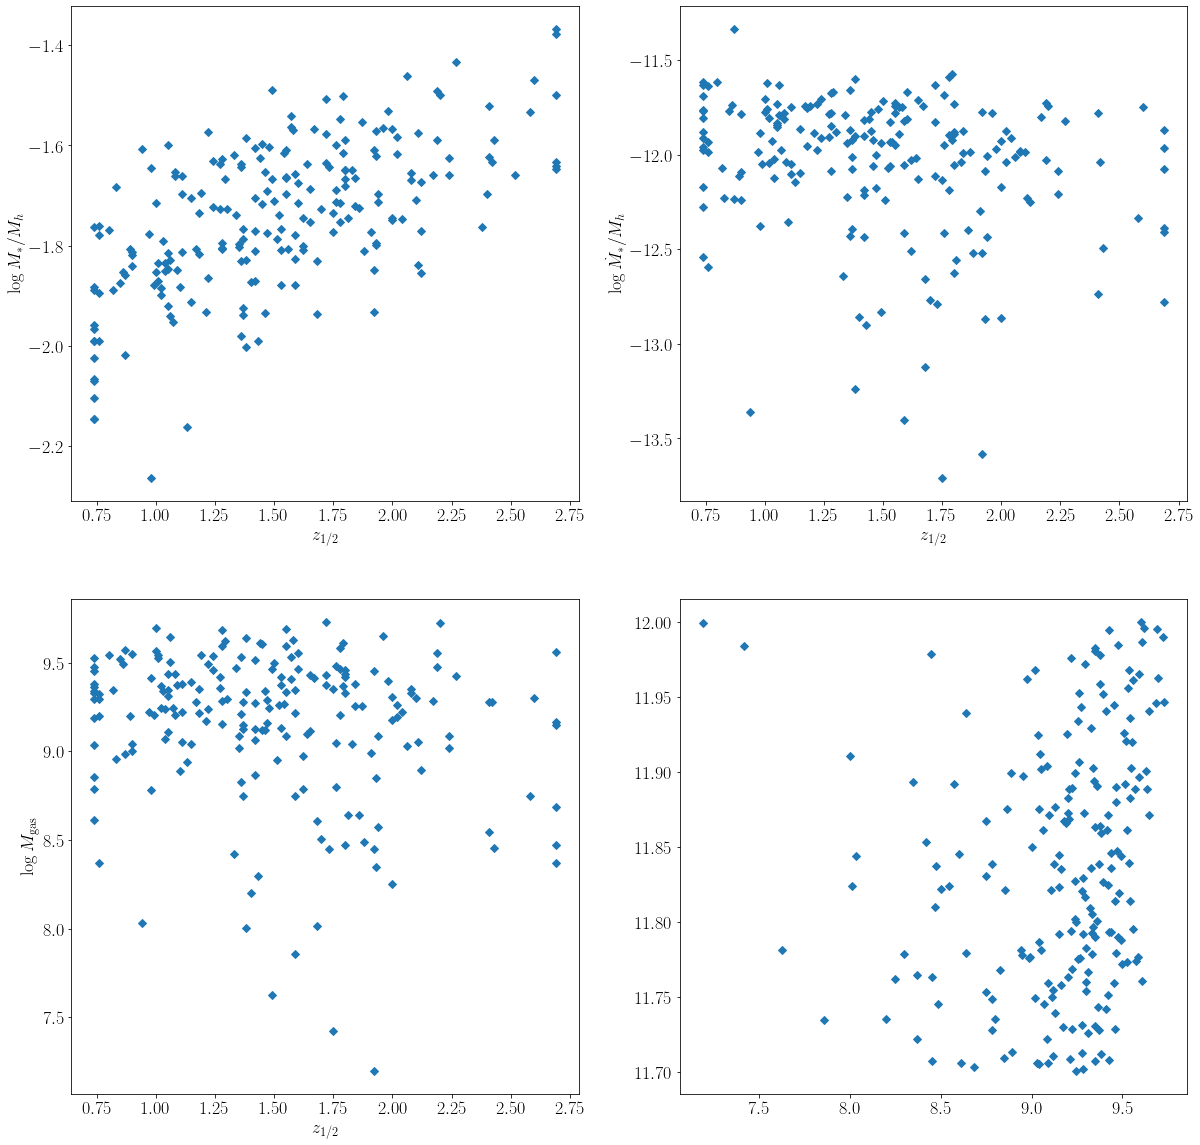

In [486]:


# collect output for a given snapnum (snap)
snapnum = 28
myvars  = ['mstar', 'sfgas', 'sfr', 'm']
select  = {}
for var in myvars:
    select[var] = []
select['z0p5']  = []
for i, descmass in enumerate(descMasses):
    select['z0p5'].append(results[i]['z0p5'])
    mask = results[i]["snapnum"] == snapnum
    for var in myvars:
        select[var].append(results[i][var][mask][0])

for var in myvars:
    select[var] = np.array(select[var])
    

# stellar mass versus formation redshift        
fig, ax = plt.subplots(2,  2, figsize = (20, 20))
ax[0,0].plot(select["z0p5"][:], np.log10(select["mstar"][:]/select["m"][:]), 'D')
ax[0,1].plot(select["z0p5"][:], np.log10(select["sfr"][:]/select["m"][:]), 'D')
ax[0,0].set_xlabel(r"$z_{1/2}$")
ax[0,0].set_ylabel(r"$\log M_\ast/M_h$")
ax[0,1].set_xlabel(r"$z_{1/2}$")
ax[0,1].set_ylabel(r"$\log \dot M_\ast/M_h$")


ax[1,0].plot(select["z0p5"][:], np.log10(select["sfgas"][:]), 'D')
ax[1,0].set_xlabel(r"$z_{1/2}$")
ax[1,0].set_ylabel(r"$\log M_{\rm gas}$")


ax[1,1].plot(np.log10(select["sfgas"][:]), np.log10(select["m"][:]), 'D')

fig.show()

According to Correa, a fit to the growth of the halo is of the form

$$M_h = (1+z)^a\,\exp(-bz)\,M_{h,0}\,.$$


Compute a and b, given $z_{12}$ and $z_{34}$. The latter are the redshifts where the mass is 1/2 and 3/4 of the mass at z=0


\begin{align}
\frac{1}{2} &= (1+z_{12})^a\,\exp(-bz_{12})\\
\frac{3}{4} &= (1+z_{34})^a\,\exp(-bz_{34})\,.
\end{align}

Take the log of both sides, and then multiply the first (second) equation with $\ln(3/4)$ ($\ln(1/2)$) and subtract, we can solve for $a$


$a = \frac{\ln(1/2)z_{34}-\ln(3/4)z_{12}}
{z_{34}\ln(1+z_{12})-z_{12}\ln(1+z_{34})}$

and

$b=\frac{a\ln(1+z_{12})-\log(1/2)}{\ln z_{12}}\,.$


In [316]:
mask         = (dbase['galaxyID'] == galaxyID) & (dbase['snapnum'] == snapmax)
descmass     = dbase['mass'][mask]
topleafID    = dbase['topleafID'][mask]
lastprogID   = dbase['lastprogID'][mask]
#
mask         = (dbase["progenitorID"] >= galaxyID) & (dbase['progenitorID'] <= topleafID)
snapshots    = dbase['snapnum'][mask]
progIDS      = dbase[mask]
fofIDS       = dbase['fof_ID'][mask]
groupIDs     = dbase['groupID'][mask]

#
masses = {}
for snapshot, progid, fofid in zip(snapshots, progIDS, fofIDS):
    masses[snapshot] = {}
    
    # all progenitors in this snapshot
    mask  = (dbase["progenitorID"] >= galaxyID) & (dbase['progenitorID'] <= lastprogID) & (dbase['snapnum'] == snapshot)
    # the fof groups they inhabit
    fofs  = np.unique(dbase["fof_ID"][mask])
    #
    fof_mass = []
    for fof in fofs:
        mask = (dbase["fof_ID"] == fof) & (dbase["snapnum"] == snapshot)
        fof_mass.append(np.sum(dbase["mass"][mask]))
    masses[snapshot]['groups'] = fof_mass
    
    # same for main branch progenitors
    mask  = (dbase["progenitorID"] >= galaxyID) & (dbase['progenitorID'] <= topleafID) & (dbase['snapnum'] == snapshot)
    # the fof groups they inhabit
    fofs  = np.unique(dbase["fof_ID"][mask])
    prog  = dbase["progenitorID"][mask]
    #
    masses[snapshot]['main']     = dbase["fof_mass"][mask]
    masses[snapshot]['redshift'] = dbase['redshift'][mask]

        

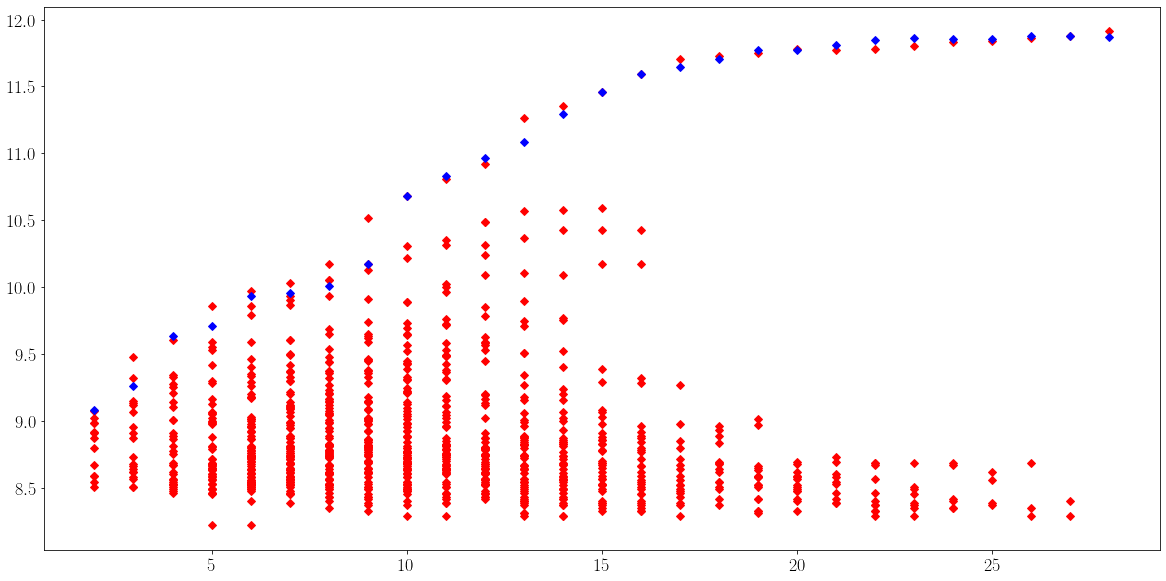

In [321]:
fig, ax = plt.subplots(1,  1, figsize = (20, 10))


for snapshot in snapshots:
    for m in masses[snapshot]["groups"]:
        ax.plot(snapshot, np.log10(m), 'D', color='red')
    ax.plot(snapshot, np.log10(masses[snapshot]['main']), 'D', color='blue')
fig.show()

## Visualization of the merger history of a given halo

In [274]:
mask         = (dbase['galaxyID'] == galaxyID) & (dbase['snapnum'] == snapmax)
print(np.sum(mask)) 
descmass     = dbase['mass'][mask]
topleafID    = dbase['topleafID'][mask]
lastprogID   = dbase['lastprogID'][mask]
print("GalaxyID = ", galaxyID, np.log10(descmass), topleafID, lastprogID )

# get all progenitors of this halo
mask         = (dbase["progenitorID"] >= galaxyID) & (dbase['progenitorID'] <= lastprogID)
progs        = {}
main         = {}
snapshots    = np.arange(18, 20, 1)

for snapshot in snapshots:
    # all progenitors
    progs[snapshot] = {}
    mask  = (dbase["progenitorID"] >= galaxyID) & (dbase['progenitorID'] <= lastprogID) & (dbase['snapnum'] == snapshot)
    for var in variables:
        progs[snapshot][var] = dbase[var][mask]

    # main branch
    main[snapshot] = {}
    mask  = (dbase["progenitorID"] >= galaxyID) & (dbase['progenitorID'] <= topleafID) & (dbase['snapnum'] == snapshot)
    for var in variables:
        main[snapshot][var] = dbase[var][mask]


1
GalaxyID =  9647056 [11.920316] [9647082] [9648215]


[18013200005842 18018300005762 18018300005837 18022200005154
 18005100004279 18013500008262 18017200001748 18016900004849
 18000000004343 18000000004343 18000000004343 18000000004343
 18000000004343 18000000004343 18000000004343 18000000005385
 18000000005385 18000000005385 18000000005385 18000000005385
 18000000005385 18000000005385 18000000005385 18000000005385
 18000000005385 18000000005385 18000000005385 18000000005385
 18000000005385 18000000005385 18000000005385 18000000005385
 18022200005052 18003900002046 18017700007141 18000300007026
 18007800007500 18000200005594 18000200005594 18000400005883
 18000200005594 18003300001909 18004000007544]
[1226843 1698500 1698575 2058603  476030 1257013 1592747 1568100    4344
    4344    4344    4344    4344    4344    4344    5386    5386    5386
    5386    5386    5386    5386    5386    5386    5386    5386    5386
    5386    5386    5386    5386    5386 2058501  362797 1644385   34777
  729001   24095   24095   42884   24095  307160  3

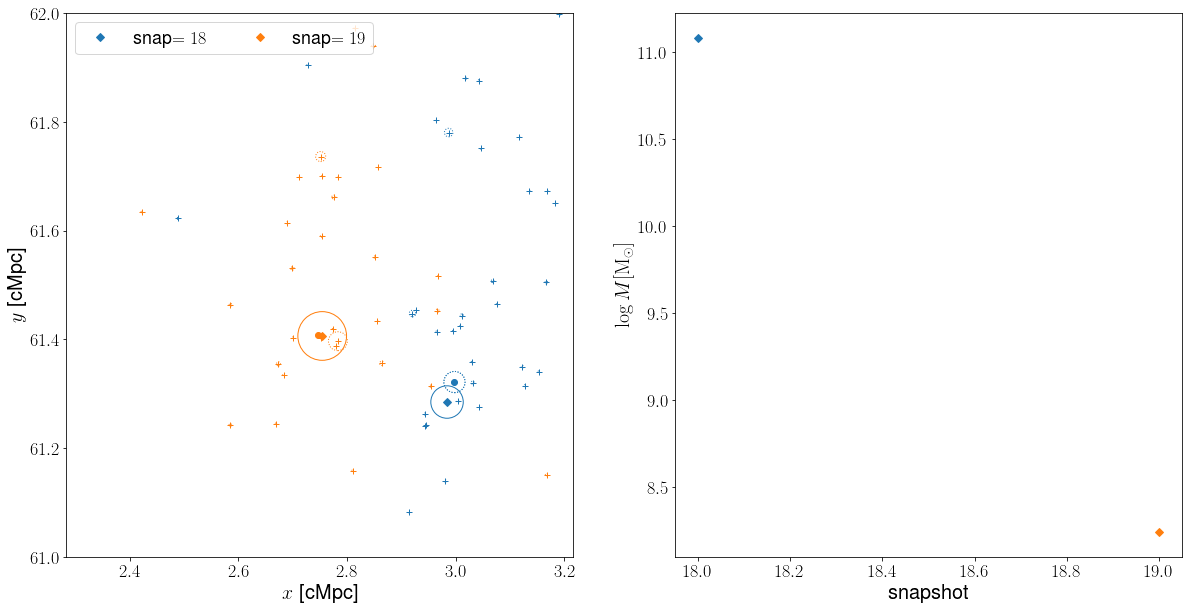

In [278]:
fig, ax = plt.subplots(1,  2, figsize = (20, 10))



nplot = len(snapshots)
plt.gca().set_prop_cycle(
plt.cycler('color', plt.cm.CMRmap(np.linspace(0., 1., nplot + 1))))
cycle   = plt.rcParams['axes.prop_cycle'].by_key()['color']
nsys    = np.arange(nplot)
#
from matplotlib.lines import Line2D
symbols = Line2D.markers


for snapshot, isys in zip(snapshots, nsys):
    color = cycle[isys%10]

    # plot fof groups
    for x, y, r, redshift in zip(main[snapshot]['fof_x'][:], main[snapshot]['fof_y'][:], main[snapshot]['fof_r200'][:], main[snapshot]['redshift'][:],):    
        circle = plt.Circle((x, y), r/(1+redshift)/1e3, color=color, fill=False) # convert from pkpc to cMpc        
        ax[0].add_patch(circle)
        ax[0].plot(x, y, 'D', color=color, label=r"snap$={0:2d}$".format(snapshot))
        
    # plot subfind groups
    for x, y, r, redshift in zip(main[snapshot]['x'][:], main[snapshot]['y'][:], main[snapshot]['rad'][:], main[snapshot]['redshift'][:],):
        circle = plt.Circle((x, y), r/(1+redshift)/1e3, color=color, fill=False, linestyle='dotted') # convert from pkpc to cMpc
        ax[0].add_patch(circle)
        ax[0].plot(x, y, 'o', color=color)
    
        
    for x, y, r, redshift in zip(progs[snapshot]['x'][:], progs[snapshot]['y'][:], progs[snapshot]['rad'][:], progs[snapshot]['redshift'][:],):
        circle = plt.Circle((x, y), r/(1+redshift)/1e3, color=color, fill=False, linestyle='dotted') # convert from pkpc to cMpc
        ax[0].add_patch(circle)
        ax[0].plot(x, y, '+', color=color)
        
    # different symbol types for different groups
    xs      = progs[snapshot]['x'][:]
    ys      = progs[snapshot]['x'][:]
    groups  = progs[snapshot]['groupnumber'][:]
    print(progs[snapshot]['fof_ID'])
    print(groups)
    groupnames = np.unique(groups)
    for i, (groupname, symbol) in enumerate(zip(groupnames, symbols)):
        mask = groups == groupname
        ax[0].plot(xs[mask], ys[mask], marker=symbol, color=color)

    ax[1].plot(snapshot, np.log10(main[snapshot]['mass']), 'D-', color=color)
ax[0].axis('equal')    
ax[0].legend(ncol=3, loc='upper left')
ax[0].set_xlabel(r"$x$ [cMpc]", fontsize=fontsize)
ax[0].set_ylabel(r"$y$ [cMpc]", fontsize=fontsize)
#
ax[0].set_xlim(2.5, 3.0)
ax[0].set_ylim(61, 62)

ax[1].set_xlabel("snapshot", fontsize=fontsize)
ax[1].set_ylabel(r"$\log M [{\rm M}_\odot]$", fontsize=fontsize)
fig.show()

## Illustrate halo merger tree

According to Correa, a fit to the growth of the halo is of the form

$$M_h = (1+z)^a\,\exp(-bz)\,M_{h,0}\,.$$


Compute a and b, given $z_{12}$ and $z_{34}$. The latter are the redshifts where the mass is 1/2 and 3/4 of the mass at z=0


\begin{align}
\frac{1}{2} &= (1+z_{12})^a\,\exp(-bz_{12})\\
\frac{3}{4} &= (1+z_{34})^a\,\exp(-bz_{34})\,.
\end{align}

Take the log of both sides, and then multiply the first (second) equation with $\ln(3/4)$ ($\ln(1/2)$) and subtract, we can solve for $a$


$a = \frac{\ln(1/2)z_{34}-\ln(3/4)z_{12}}
{z_{34}\ln(1+z_{12})-z_{12}\ln(1+z_{34})}$

and

$b=\frac{a\ln(1+z_{12})-\log(1/2)}{\ln z_{12}}\,.$





In [11]:
# fits from Correa
def mh(z):
    a = 0.24
    b = 0.75
    return (1+z)**a * np.exp(-b*z)


In [17]:
print(1+1)
print(snapnum)

2
28


/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log10


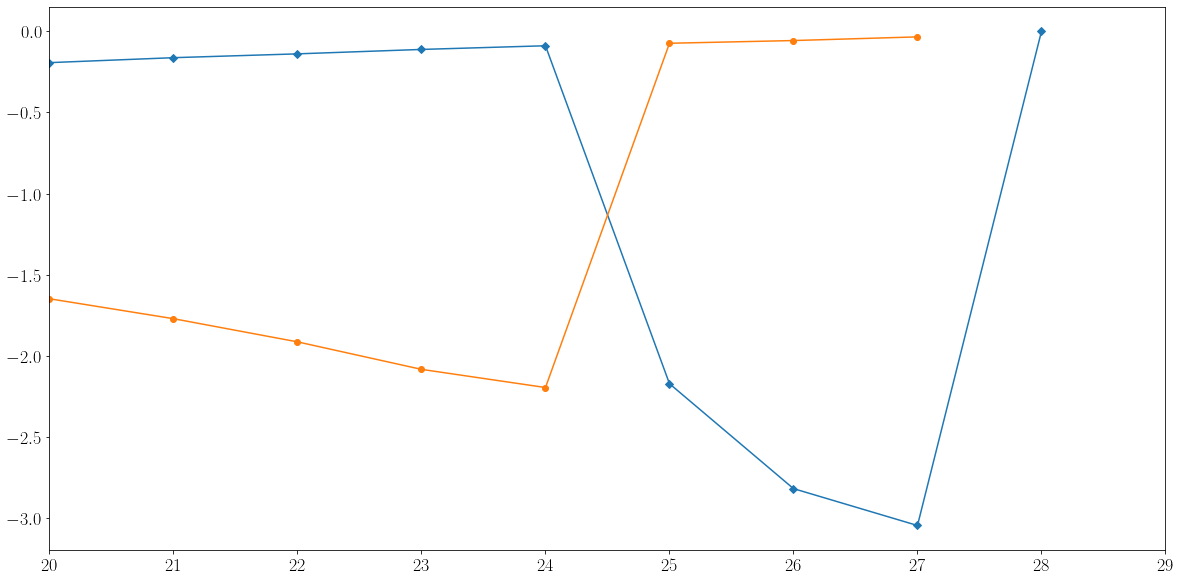

In [42]:
fig, ax = plt.subplots(1,  1, figsize = (20, 10))

snapnum = 28

# extract and plot merger tree for each z=0 decendant
mask           = dbase['snapnum'] == snapnum
descIDs        = dbase['descID'][mask]
descMasses     = dbase['mass'][mask]
progMasses     = dbase['mass']
topleafIDs     = dbase['topleafID'][mask]
lastprogIDs    = dbase['lastprogID'][mask]
progIDs        = dbase['progID']
snaps          = dbase['snapnum']
progzs         = dbase['redshift']

for i, (desc, topleaf, lastprog, descMass) in enumerate(zip(descIDs, topleafIDs, lastprogIDs, descMasses)):
    if i == 100:
        mask  = (progIDs >= desc) & (progIDs <= lastprog) 
        mains = []
        mergs = []
        zs    = []
        sn    = []
        for snapshot in np.arange(4, snapnum+1, 1):
            # identify main progenitor
            mask   = (progIDs >= desc) & (progIDs <= topleaf) & (snaps == snapshot)
            main   = progMasses[mask][0]
            mains.append(main) # mass of main progenitor
            zs.append(progzs[mask][0])
            sn.append(snaps[mask][0])
            
            # identify all other progenitors
            mask   = (progIDs >= desc) & (progIDs <= lastprog) & (snaps == snapshot)
            merg   = np.sum(progMasses[mask]) - main # sub of all progenitors minus mass of main branch
            mergs.append(merg)
        ax.plot(sn, np.log10(mains/descMass), 'D-')
        ax.plot(sn, np.log10(mergs/descMass), 'o-')
#         print(mergs)
#         print(main)
zs = np.arange(0, 10, 0.1)
ax.plot(zs, np.log10(mh(zs)), '+-', color='blue')

#             ax.plot(snap, np.log10((np.sum(masses)-main)/descMass), '-o', color='blue')
ax.set_xlim(20,29)


fig.show()

In [50]:
# select a single halo
nhalo          = 100
mask           = dbase['snapnum'] == 25
GroupNumber    = dbase['descgroup'][mask]
SubGroupNumber = dbase['descsubgroup'][mask]
X              = dbase['x'][mask]
Y              = dbase['y'][mask]
Z              = dbase['z'][mask]
# for i in np.arange(10):
#     print(i, GroupNumber[i], X[i], Y[i], Z[i])
# print(GroupNumber[0], X[0], Y[0], Z[0])

In [51]:
centre    = np.array([X[nhalo], Y[nhalo], Z[nhalo]]) 
radius    = 1.0
sphere    = {'centre':centre*HubbleParam, 'radius':radius*HubbleParam} # database is in cMpc, but particles are in cMpc/h
variables = [{'type':1, 'name':'Coordinates'}, {'type':1, 'name':'SubGroupNumber'}, {'type':1, 'name':'GroupNumber'}]
parts     = mtree.QuerySnap(sphere=sphere, variables=variables, snapnum=25, verbose=True)

Read type  1, name = Coordinates, length: 2.880e+05
Read type  1, name = SubGroupNumber, length: 2.880e+05
Read type  1, name = GroupNumber, length: 2.880e+05


In [52]:
Groups = parts[1]['GroupNumber']['Values']
Subs   = parts[1]['SubGroupNumber']['Values']
for i in np.arange(10):
    print(i, parts[1]['Coordinates']['Values'][i,:], Groups[i], Subs[i])
print(X[nhalo], Y[nhalo], Z[nhalo], GroupNumber[nhalo])
mask = Groups == GroupNumber[nhalo]
print(np.sum(mask))
print(GroupNumber[nhalo], SubGroupNumber[nhalo])

0 [66.61262786  8.94263348 23.77519685] 94035 0
1 [66.61100603  8.93925466 23.75987228] 94035 0
2 [66.62639843  8.93330873 23.79543276] 94035 0
3 [66.62550031  8.93597951 23.77970595] 94035 0
4 [66.63004248  8.91975613 23.78611726] -94035 1073741824
5 [66.62726668  8.92014291 23.79060723] -94035 1073741824
6 [66.62910827  8.91926971 23.79205064] -94035 1073741824
7 [66.64513467  8.94218526 23.79591988] 94035 0
8 [66.66504685  8.93964427 23.79476446] 94035 0
9 [66.6427057   8.93872392 23.78065252] 94035 0
67.41382 9.47545 24.573114 1994
82438
1994 0


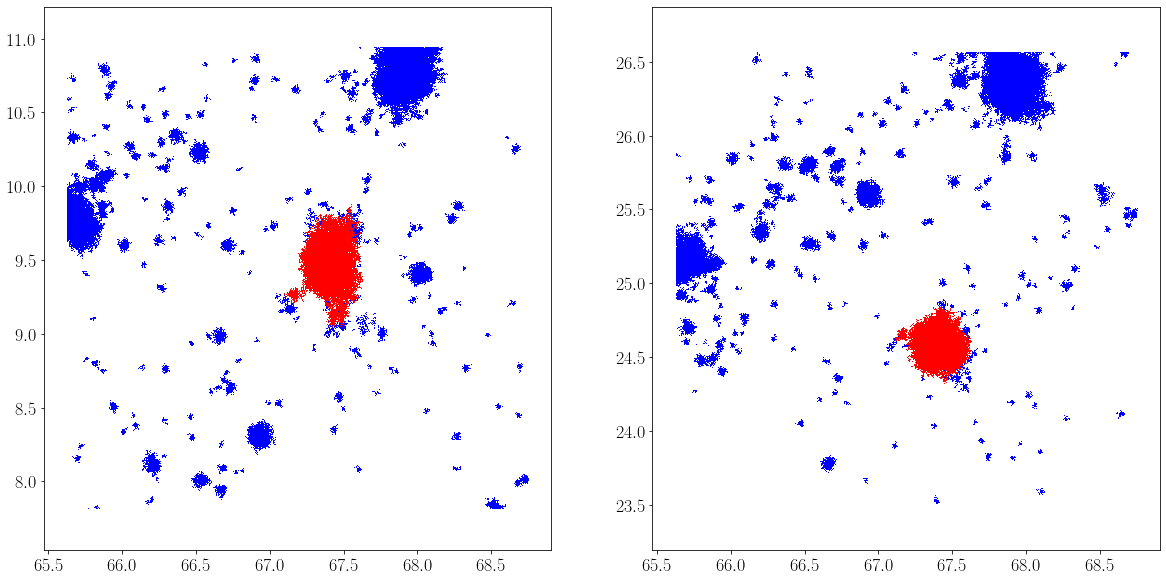

In [53]:
# plot selected subhalo

fig, ax = plt.subplots(1,  2, figsize = (20, 10))

# x-y
IXs = [0,0]
IYs = [1,2]
for i, ix, iy in zip(np.arange(2), IXs, IYs):
    ax[i].set_xlim(centre[ix]-radius, centre[ix]+radius)  
    ax[i].set_ylim(centre[iy]-radius, centre[iy]+radius)  
    ax[i].axis('equal')
    mask = parts[1]['GroupNumber']['Values'] > 0
    ax[i].plot(parts[1]['Coordinates']['Values'][:,ix][mask], 
               parts[1]['Coordinates']['Values'][:,iy][mask], ',', color='blue')
    mask = parts[1]['GroupNumber']['Values'] == GroupNumber[nhalo]
    ax[i].plot(parts[1]['Coordinates']['Values'][mask,ix], parts[1]['Coordinates']['Values'][mask,iy], ',', color='red')


fig.show()



In [ ]:
pars = {'sim_name':'RefL0100N1504','m_min':5e11,'m_max':1e12,'fraction':0.5
        ,'snapnum':26, 'eaglesim':L0100N1504/PE/REFERENCE'}

def QueryDB(pars={'sim_name':'RefL0100N1504','m_min':5e11,'m_max':1e12,'fraction':0.5,'snapnum':26}):

    mhistory = 'SELECT \
                      DES.GalaxyID as descID, \
                      PROG.GalaxyID as progID, \
                      DES.TopLeafID as topleafID, \
                      PROG.TopLeafID as progtopleafID,\
                      PROG.LastProgID as lastprogID, \
                      PROG.DescendantID as descendantID, \
                      PROG.Redshift as z, \
                      PROG.Vmax as vmax, \
                      PROG.MassType_DM as mass, \
                      PROG.Snapnum as snapnum, \
                      PROG.Starformationrate as SFR \
              FROM \
                      {0}_Subhalo as PROG, \
                      {0}_Subhalo as DES \
              WHERE \
                      DES.MassType_DM between {1:1.2e} and {2:1.2e} \
                      and DES.RandomNumber < {3:1.3f} \
                      and DES.SnapNum = {4:3d} \
                      and PROG.GalaxyID between DES.GalaxyID and DES.TopLeafID \
              ORDER BY \
                      PROG.Redshift asc'.format(pars['sim_name'], pars['m_min'], pars['m_max'], pars['fraction']
                                                , pars['snapnum'])
    return sql.execute_query(conSQL, mhistory)

## ReadEagle example

In [ ]:


eaglebase  = '/cosma7/data/Eagle/ScienceRuns/Planck1/'
eaglesim   = 'L0100N1504/PE/REFERENCE'
subbase    = 'particledata_'
partbase   = 'eagle_subfind_particles_'

def snapbase(snapnum):
    ''' return file base'''
    bases      = ['000_z020p000', '001_z015p132', '002_z009p993'
              , '003_z008p988', '004_z008p075', '005_z007p050'
              , '006_z005p971', '007_z005p487', '008_z005p037'
              , '009_z004p485', '010_z003p984', '011_z003p528'
              , '012_z003p017', '013_z002p478', '014_z002p237'
              , '015_z002p012', '016_z001p737', '017_z001p487'
              , '018_z001p259', '019_z001p004', '020_z000p865'
              , '021_z000p736', '022_z000p615', '023_z000p503'
              , '024_z000p366', '025_z000p271', '026_z000p183'
              , '027_z000p101', '028_z000p000']
    try:
        return bases[snapnum]
    except:
        print('This snapshot does not exists, sorry')

snapnum     = 28
infile      = eaglebase + eaglesim + '/data/' + subbase + snapbase(snapnum) + '/' + partbase + snapbase(snapnum) + '.0.hdf5'
RE          = read_eagle.EagleSnapshot(infile)

In [ ]:
# units for select region are co-moving Mpc - i.e. the same as the coordiantes of the particles
rmin        = [0,0,0]
rmax        = [1,1,1]
RE.select_region(rmin[0], rmax[0], rmin[1], rmax[1], rmin[2], rmax[2])
Coordinates = RE.read_dataset(1,'Coordinates')

In [ ]:
print(Coordinates[0:10])

In [ ]:
mask     = dbase['snapnum'] == pars['snapnum']
descs    = dbase['progID'][mask]
topleafs = dbase['topleafID'][mask]
descid   = dbase['topleafID'][mask]
trees    = {}
for (desc, topleaf) in zip(descs, topleafs):
    trees[desc] = {}
    trees[desc]['topleaf'] = topleaf
    mask        = (dbase['progID'] >= desc) & (dbase['progID'] <= topleaf)
    trees[desc]['progID']  = dbase['progID'][mask]
    trees[desc]['mass']    = dbase['mass'][mask]
    trees[desc]['vmax']    = dbase['vmax'][mask]
    trees[desc]['snapnum'] = dbase['snapnum'][mask]

In [ ]:
print(len(dbase['descendantid']))
print(len(dbase['progID']))

In [ ]:
mask     = dbase['snapnum'] == pars['snapnum']
descs    = dbase['progID'][mask]
topleafs = dbase['topleafID'][mask]
mdescs   = dbase['mass'][mask]
snaps    = dbase['snapnum'][mask]
trees    = {}

print(descs[0:5])
print(topleafs[0:5])
print(mdescs[0:5])
print(snaps[0:5])
for (desc, topleaf, mdesc) in zip(descs, topleafs, mdescs):
    trees[desc] = {}
    trees[desc]['mass'] = mdesc   # mass of descendant

    # identify mergers
    mask       = dbase['descendantID'] == desc
    if np.sum(mask) > 1:
        print(desc, topleaf, dbase['progID'][mask], np.sum(mask))
    galaxyids  = dbase['progID'][mask]
    topleafids = dbase['topleafID'][mask]
    masses     = []
    # for each merger, find maximum mass of its progenitor along the merger tree
    for (galaxyid, topleafid) in zip(galaxyids, topleafids):
        mask = (dbase['progID'] >= galaxyid) & (dbase['progID'] <= topleafid)
        mass = np.max(dbase['mass'][mask])
        masses.append(mass)
    trees[desc]['mass_progs'] = masses # max masses of all progeniters
    
for i, desc in enumerate(descs):
    if i < 20:
        print(i, trees[desc]['mass'], trees[desc]['mass_progs']/trees[desc]['mass'])

In [ ]:
# for (i, desc) in enumerate(descs):
#     topleaf     = trees[desc]['topleaf']
#     mask        = (dbase['progID'] >= desc) & (dbase['progID'] <= topleaf)
#     snaps       = dbase['snapnum'][mask]
#     gals        = dbase['progID'][mask]
#     print(i, desc, snaps)

## Analyse merger history

In [ ]:
fig, ax = plt.subplots(1,  1, figsize = (10, 10))
for (i, desc) in enumerate(descs):
    topleaf     = trees[desc]['topleaf']
    snaps       = trees[desc]['snapnum']
    mass        = trees[desc]['mass']
    vmax        = trees[desc]['vmax']
    if i < 100:
        ax.plot(snaps, (vmax/vmax[0]))
ax.set_xlim(15, 28)        
ax.set_ylim(0, 3)



fig.show()

In [ ]:
def GrowthParams(z12=2, z34=1):
  ''' Solve for parameters (a,b) such that 1/2 mass formed at redshift z=z12, and 3/4 and z34'''
  ln12  = np.log(1./2.)
  ln34  = np.log(3./4.)
  a     = np.log(1./2.) * z34 - np.log(3./4) * z12
  a    /= (z34 * np.log(1+z12) - z12 * np.log(1+z34))
  b     = (a * np.log(1+z12) - np.log(1./2.)) / z12
  return a, b


#
z12 = 3.
z34 = 1.
a, b = GrowthParams(z12=z12, z34=z34)
print(a, b, Mh(z12, a=a, b=b), Mh(z34, a=a, b=b))